In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = \delta(x-y)
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain and $\delta(x-y)$ corresponds to a localised source term such can be a well in subsurface reservoirs.  

Our goal is to create params to solutions models, this time a mapping from y to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [5]:
from solvers.Solver import Solver
from config_step_2 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 101 points for discretizations

In [6]:
def delta(y, x, dy = 1., dx = 0.) :
    """    
    y : int, float or ndarray of size 1
    x : ndarray
    
    return dy if x = y and dx otherwise
    """
    if torch.is_tensor(y):
        return torch.where(torch.Tensor(x) == y, dy, dx)
    return np.where(x == y, dy, dx)

In [7]:
PARAMS_SOLVER['source_term'] = lambda y, x : delta(y, x)
PARAMS_SOLVER['y'] = 0.2

In [8]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = Solver(params={'solver': params_solver})

In [9]:
u = solver.solve()

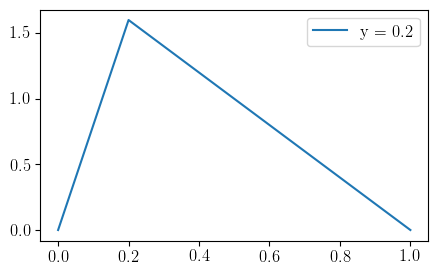

In [10]:
plt.plot(solver.x, u, label=f'y = {solver.Y}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [11]:
# As we use a dirac, we need the values of y to correspond with the grid
Y_list = solver.x[20:81].reshape(-1, 1)

In [12]:
U_sols = []
for y in Y_list:
    solver.change_y(new_y= y)
    U_sols.append(solver.solve())
U_sols = np.stack(U_sols)

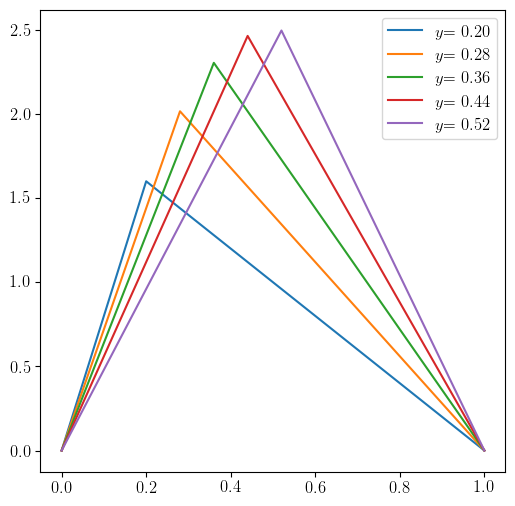

In [13]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in range(0, 40, 8):
    axs.plot(solver.x, U_sols[sample], label=f'$y$= {Y_list[sample, 0]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [14]:
from methods.DataDrivenMethods import DDMethod

In [15]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO']

#method_names = ['PINN'] 

Best model parameters and optimization hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them (see optuna folder for more detail on the training)

In [16]:
from config_step_2 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [17]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 24, 28, 11, 18, 21, 1],
 'activations': 'tanh',
 'device': device(type='cpu'),
 'seed': 123}

Create DDMethod object for each method

In [18]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [19]:
Y_train, Y_val, U_train, U_val = sklearn.model_selection.train_test_split(Y_list, U_sols, test_size=0.2, random_state=123)

In [20]:
delta_Y_train = delta(Y_train, solver.x)
delta_Y_val = delta(Y_val, solver.x)

In [21]:
nx = PARAMS_SOLVER['nx']

x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(Y_train.shape[0], 1)
X_val = x.repeat(Y_val.shape[0], 1)


Y_train_repeated = torch.Tensor(Y_train.repeat(nx, 1).reshape(-1, 1))
Y_val_repeated = torch.Tensor(Y_val.repeat(nx, 1).reshape(-1, 1))


YX_train = torch.cat((Y_train_repeated, X_train), dim=1)
YX_val = torch.cat((Y_val_repeated, X_val), dim=1)
YU_train = torch.Tensor(U_train).view(-1, 1)
YU_val = torch.Tensor(U_val).view(-1, 1)

In [22]:
Y_fno_train = torch.Tensor(delta_Y_train).unsqueeze(-1)
Y_fno_val = torch.Tensor(delta_Y_val).unsqueeze(-1)

Load models for Neural Networks, and fit for POD

In [25]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=U_sols)
    elif method in ['MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO']:
        all_methods[method].load_state_dict(f'optuna/step_2/{method}.pt')
        
    # elif method == 'FNO':
    #     all_methods[method].fit(hyperparameters=hyperparams_method, 
    #                             D_train=Y_fno_train, D_val=Y_fno_val, U_train=U_train, U_val=U_val)
        
    # elif method == 'DEEPONET':
    #     all_methods[method].fit(hyperparameters=hyperparams_method, 
    #                             U_train=U_train, U_val=U_val, D_train=delta_Y_train, D_val=delta_Y_val)
        
    # elif method in ['MLP']:
    #     all_methods[method].fit(hyperparameters=hyperparams_method, 
    #                             U_train=YU_train, U_val=YU_val, DX_train=YX_train, DX_val=YX_val, 
    #                             data_ratio=1., physics_ratio=0.)
        
    # elif method == 'PINN':
    #     all_methods[method].fit(hyperparameters=hyperparams_method, 
    #                              DX_train=YX_train, DX_val=YX_val, U_val=YU_val, 
    #                             data_ratio=0., physics_ratio=1., loss='Y', w_r=11)
       
    # elif method == 'MLPINN':
    #     all_methods[method].fit(hyperparameters=hyperparams_method, DX_train=YX_train, DX_val=YX_val, U_train=YU_train, U_val=YU_val,
    #                        data_ratio=1., physics_ratio=1., loss='Y')
        

Fitting POD
POD fitted


In [26]:
# for method in all_methods:
#     if method in ['MLP', 'PINN', 'DEEPONET', 'FNO', 'MLPINN']:
#         torch.save({'model_state_dict': all_methods[method].state_dict,
#              'loss_dict': all_methods[method].loss_dict(),
#              }, f'optuna/step_2/{method}.pt')

# Plot performances for each method

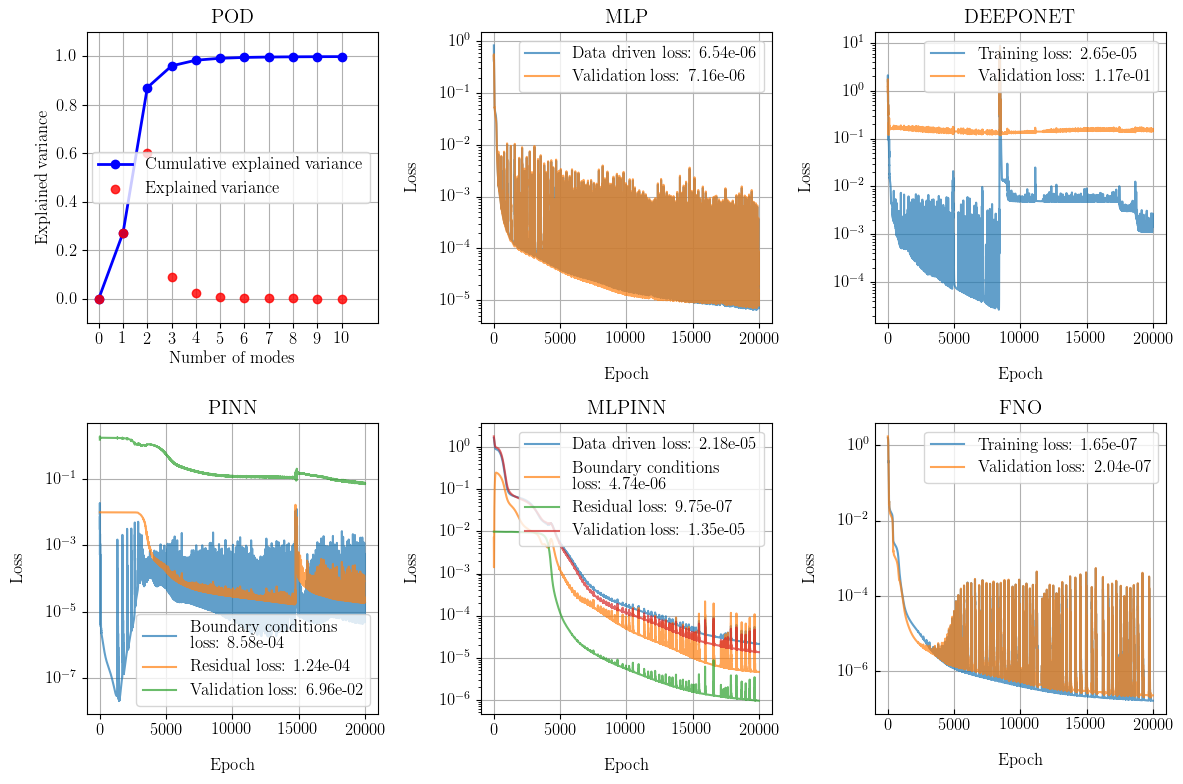

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

## In distribution analysis

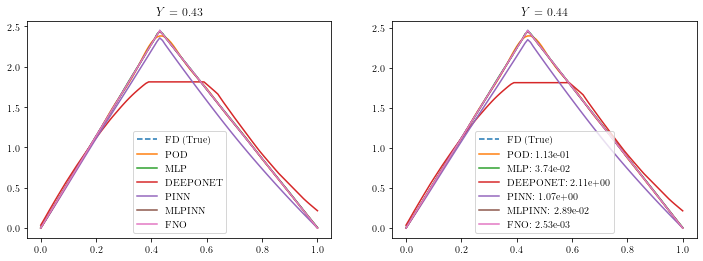

In [29]:
new_y = 0.43
solver.change_y(new_y=new_y)
U_FD = solver.solve()
fx = solver.fx
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (12, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    if method == 'POD':
        U_pred = all_methods[method].apply_method(phi = new_y, y = new_y).flatten()
        ax_0.plot(solver.x, U_pred, label=f'{method}')
    elif method == 'FNO':
        U_pred = all_methods[method].apply_method(phi = fx, y = fx).flatten()
        ax_0.plot(solver.x, U_pred, label=f'{method}')
    elif method == 'DEEPONET':
        U_pred = all_methods[method].apply_method(phi = [new_y], y = [new_y]).flatten()
        ax_0.plot(solver.x, U_pred, label=f'{method}')
    elif method == 'MLP':
        U_pred = all_methods[method].apply_method(phi= [new_y], y = [new_y]).flatten()
        ax_0.plot(solver.x, U_pred, label=f'{method}')
    elif method == 'MLPINN':
        U_pred = all_methods[method].apply_method(phi= [new_y], y = [new_y]).flatten()
        ax_0.plot(solver.x, U_pred, label=f'{method}')
    elif method == 'PINN':
        U_pred = all_methods[method].apply_method(phi= [new_y], y = [new_y]).flatten()
        ax_0.plot(solver.x, U_pred, label=f'{method}')
ax_0.title.set_text(f'$Y$ = {new_y}')
ax_0.legend()

new_OOD_y = 0.44
solver.change_y(new_y=new_OOD_y)
U_FD = solver.solve()
fx_OOD = solver.fx

ax_1.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    if method == 'POD':
        U_pred = all_methods[method].apply_method(phi = new_OOD_y, y=new_OOD_y).flatten()
    elif method == 'FNO':
        U_pred = all_methods[method].apply_method(phi = fx_OOD, y = fx_OOD).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi = [new_OOD_y], y = [new_OOD_y]).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}: {np.linalg.norm(U_pred - U_FD, 2):.2e}')
    

ax_1.title.set_text(f'$Y$ = {new_OOD_y}')
ax_1.legend()
plt.show()

## Parity plot